# カテゴリ値を含むデータでのLightGBMを使った分析

### データ
[Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) \
[Adult Census Income](https://www.kaggle.com/datasets/uciml/adult-census-income) \
[Adult income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)

### 参考
[lightgbmで二値分類の一連の流れをしたメモ](https://qiita.com/d_desuyon/items/807e01311ad08570ee78) \
[【初心者向け】特徴量重要度の算出 (LightGBM) 【Python】【機械学習】](https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a) \
[Pythonでしか描けない美しいデシジョンツリー（決定木）をlightGBMでも描こう！](https://qiita.com/hima2b4/items/b356e688ebdabc393da8) \
[LightGBM/XGBoostのtree構造可視化メモ](https://qiita.com/dyamaguc/items/70d4ce3548d49a6256fa) \
[Category Encodersでカテゴリ特徴量をストレスなく変換する](https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31) \
[カテゴリ変数系特徴量の前処理(scikit-learnとcategory_encoders)](https://qiita.com/FukuharaYohei/items/06cc7b1c5eb124db6cdf) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a) \
[LightGBMでOptunaを使用するときの再現性確保について](https://book-read-yoshi.hatenablog.com/entry/2021/03/22/lightgbm_optuna_deterministic)

In [1]:
!python -V

Python 3.9.13


In [2]:
!python -m pip --version

pip 23.0.1 from C:\Python39\lib\site-packages\pip (python 3.9)



In [3]:
!python -m pip list

Package                  Version
------------------------ -----------
aiofiles                 22.1.0
aiosqlite                0.18.0
alembic                  1.9.4
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
attrs                    22.2.0
Babel                    2.11.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
bs4                      0.0.1
category-encoders        2.6.0
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       3.0.1
cmaes                    0.9.1
colorama                 0.4.6
colorlog                 6.7.0
comm                     0.1.2
contourpy                1.0.7
cycler                   0.11.0
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
executing                1.2.0
fastjsonschema           2.16.2
fonttools        

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
from sklearn.model_selection import train_test_split
#import lightgbm as lgb
import optuna
# ログを非表示にしたいときは、optuna.logging.disable_default_handler()
# 逆に、表示にしたいときは、optuna.logging.enable_default_handler()
optuna.logging.disable_default_handler()
# optuna経由でLightGBMをインポート
from optuna.integration import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('adult_uci_label.csv')

In [6]:
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,216864,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,150601,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,88638,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,422013,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,172274,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,164526,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,129177,9,13,6,7,1,4,0,0,2824,20,38,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int64
 4   education.num   30162 non-null  int64
 5   marital.status  30162 non-null  int64
 6   occupation      30162 non-null  int64
 7   relationship    30162 non-null  int64
 8   race            30162 non-null  int64
 9   sex             30162 non-null  int64
 10  capital.gain    30162 non-null  int64
 11  capital.loss    30162 non-null  int64
 12  hours.per.week  30162 non-null  int64
 13  native.country  30162 non-null  int64
 14  income          30162 non-null  int64
dtypes: int64(15)
memory usage: 3.5 MB


In [8]:
columns_cat = [
    'workclass',
    'education',
    'marital.status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native.country',
    #'income',
]

In [9]:
{cat:'category' for cat in columns_cat}

{'workclass': 'category',
 'education': 'category',
 'marital.status': 'category',
 'occupation': 'category',
 'relationship': 'category',
 'race': 'category',
 'sex': 'category',
 'native.country': 'category'}

In [10]:
df = df.astype({cat:'category' for cat in columns_cat})

In [11]:
for cat in columns_cat:
    print(cat, df[cat].cat.categories)

workclass Int64Index([0, 1, 3, 4, 5, 6, 7], dtype='int64')
education Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')
marital.status Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
occupation Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
relationship Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
race Int64Index([0, 1, 2, 3, 4], dtype='int64')
sex Int64Index([0, 1], dtype='int64')
native.country Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')


In [12]:
df['income'].value_counts()

0    22654
1     7508
Name: income, dtype: int64

In [13]:
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,216864,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,150601,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,88638,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,422013,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,172274,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,164526,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,129177,9,13,6,7,1,4,0,0,2824,20,38,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30162 non-null  int64   
 1   workclass       30162 non-null  category
 2   fnlwgt          30162 non-null  int64   
 3   education       30162 non-null  category
 4   education.num   30162 non-null  int64   
 5   marital.status  30162 non-null  category
 6   occupation      30162 non-null  category
 7   relationship    30162 non-null  category
 8   race            30162 non-null  category
 9   sex             30162 non-null  category
 10  capital.gain    30162 non-null  int64   
 11  capital.loss    30162 non-null  int64   
 12  hours.per.week  30162 non-null  int64   
 13  native.country  30162 non-null  category
 14  income          30162 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 1.8 MB


In [15]:
# 不要カラムの削除と並べ替え
df = df[["age",
         "workclass",
         #"fnlwgt",
         "education",
         "education.num",
         "marital.status",
         "occupation",
         "relationship",
         "race",
         "sex",
         "capital.gain",
         "capital.loss",
         "hours.per.week",
         "native.country",
         "income",]]
df.head(10)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,3,11,9,6,3,1,4,0,0,4356,18,38,0
1,54,3,5,4,0,6,4,4,0,0,3900,40,38,0
2,41,3,15,10,5,9,3,4,0,0,3900,40,38,0
3,34,3,11,9,0,7,4,4,0,0,3770,45,38,0
4,38,3,0,6,5,0,4,4,1,0,3770,40,38,0
5,74,6,10,16,4,9,2,4,0,0,3683,20,38,1
6,68,0,11,9,0,9,1,4,0,0,3683,40,38,0
7,45,3,10,16,0,9,4,2,0,0,3004,35,38,1
8,38,5,14,15,4,9,1,4,1,0,2824,45,38,1
9,52,3,9,13,6,7,1,4,0,0,2824,20,38,1


In [16]:
X = df.drop(['income'], axis=1)
y = df['income']

#Creation of Train and Test dataset
X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.2, shuffle=False)

#Creation of Train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [17]:
print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_valid.shape, y_valid.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (19303, 13)(19303,)
Validation dataset: (4826, 13)(4826,)
Test dataset: (6033, 13)(6033,)


In [18]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [19]:
# LightGBMのハイパーパラメータ
params = {
    # 勾配ブースティング木(GBDT:Gradient Boosting Decision Tree)
    'boosting_type': 'gbdt',
    # 二値分類問題
    'objective': 'binary',
    # AUCの最大化を目指す
    'metric': 'auc',
    # 正答率の最大化を目指す
    #'metric': 'binary_error',
    # Fatal の場合出力
    'verbosity': -1,
    # 学習率
    'learning_rate': 0.02,
    'deterministic': True, # 再現性確保用のパラメータ
    'force_row_wise': True  # 再現性確保用のパラメータ
}

In [20]:
booster = lgb.LightGBMTuner(
    params = params,
    train_set = lgb_train,
    valid_sets = lgb_valid,
    verbose_eval = 50,  # 50イテレーション毎に学習結果出力
    num_boost_round = 10000,  # 最大イテレーション回数指定
    early_stopping_rounds = 100,
    categorical_feature = columns_cat, # categorical_featureを設定
    optuna_seed = 31, # 再現性確保用のパラメータ
)

In [21]:
'''
lgb.trainを利用すると再現性を確保できない
# 上記のパラメータでモデルを学習する
model = lgb.train(params, train_set=lgb_train, valid_sets=lgb_valid,
                  verbose_eval = 50,  # 50イテレーション毎に学習結果出力
                  num_boost_round = 10000,  # 最大イテレーション回数指定
                  early_stopping_rounds = 100,
                  categorical_feature = columns_cat, # categorical_featureを設定
                 )
'''
# 上記のパラメータでモデルを学習する
booster.run()

feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.897806
[100]	valid_0's auc: 0.900479
[150]	valid_0's auc: 0.903007
[200]	valid_0's auc: 0.904523
[250]	valid_0's auc: 0.905004
[300]	valid_0's auc: 0.90514
[350]	valid_0's auc: 0.905146


feature_fraction, val_score: 0.905196:  14%|######4                                      | 1/7 [00:00<00:05,  1.03it/s]

[400]	valid_0's auc: 0.905071
Early stopping, best iteration is:
[322]	valid_0's auc: 0.905196
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.896263
[100]	valid_0's auc: 0.899584
[150]	valid_0's auc: 0.902213
[200]	valid_0's auc: 0.903541
[250]	valid_0's auc: 0.904386
[300]	valid_0's auc: 0.904599


feature_fraction, val_score: 0.905196:  29%|############8                                | 2/7 [00:01<00:04,  1.14it/s]

[350]	valid_0's auc: 0.904416
Early stopping, best iteration is:
[299]	valid_0's auc: 0.904604
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.898819
[100]	valid_0's auc: 0.900922
[150]	valid_0's auc: 0.903147
[200]	valid_0's auc: 0.904448
[250]	valid_0's auc: 0.904945
[300]	valid_0's auc: 0.905102
[350]	valid_0's auc: 0.905161
[400]	valid_0's auc: 0.905013
Early stopping, best iteration is:
[338]	valid_0's auc: 0.905191


feature_fraction, val_score: 0.905196:  43%|###################2                         | 3/7 [00:02<00:03,  1.12it/s]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.900977
[100]	valid_0's auc: 0.901689
[150]	valid_0's auc: 0.903351
[200]	valid_0's auc: 0.904775
[250]	valid_0's auc: 0.905418
[300]	valid_0's auc: 0.905652
[350]	valid_0's auc: 0.905724
[400]	valid_0's auc: 0.905779
[450]	valid_0's auc: 0.905621
Early stopping, best iteration is:
[378]	valid_0's auc: 0.905858


feature_fraction, val_score: 0.905858:  57%|#########################7                   | 4/7 [00:03<00:02,  1.04it/s]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902664
[100]	valid_0's auc: 0.904155
[150]	valid_0's auc: 0.90514
[200]	valid_0's auc: 0.905737
[250]	valid_0's auc: 0.906364
[300]	valid_0's auc: 0.90656
[350]	valid_0's auc: 0.906693
[400]	valid_0's auc: 0.906715
[450]	valid_0's auc: 0.906831
[500]	valid_0's auc: 0.906693
Early stopping, best iteration is:
[434]	valid_0's auc: 0.906875


feature_fraction, val_score: 0.906875:  71%|################################1            | 5/7 [00:04<00:02,  1.02s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.899916
[100]	valid_0's auc: 0.901258
[150]	valid_0's auc: 0.903585
[200]	valid_0's auc: 0.904763
[250]	valid_0's auc: 0.905475
[300]	valid_0's auc: 0.905748
[350]	valid_0's auc: 0.905854


feature_fraction, val_score: 0.906875:  86%|######################################5      | 6/7 [00:05<00:01,  1.00s/it]

[400]	valid_0's auc: 0.905631
[450]	valid_0's auc: 0.905481
Early stopping, best iteration is:
[360]	valid_0's auc: 0.905875
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.895159
[100]	valid_0's auc: 0.899195
[150]	valid_0's auc: 0.902019
[200]	valid_0's auc: 0.903495
[250]	valid_0's auc: 0.904103
[300]	valid_0's auc: 0.904035


feature_fraction, val_score: 0.906875: 100%|#############################################| 7/7 [00:06<00:00,  1.06it/s]


[350]	valid_0's auc: 0.904001
Early stopping, best iteration is:
[257]	valid_0's auc: 0.904144


num_leaves, val_score: 0.906875:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903691
[100]	valid_0's auc: 0.90469
[150]	valid_0's auc: 0.905297
[200]	valid_0's auc: 0.905468
[250]	valid_0's auc: 0.90563
[300]	valid_0's auc: 0.905633
[350]	valid_0's auc: 0.90543


num_leaves, val_score: 0.906875:   5%|##5                                               | 1/20 [00:01<00:23,  1.22s/it]

Early stopping, best iteration is:
[269]	valid_0's auc: 0.905744
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903041
[100]	valid_0's auc: 0.903565
[150]	valid_0's auc: 0.903753
[200]	valid_0's auc: 0.903599
[250]	valid_0's auc: 0.903375


num_leaves, val_score: 0.906875:  10%|#####                                             | 2/20 [00:02<00:23,  1.30s/it]

Early stopping, best iteration is:
[165]	valid_0's auc: 0.903988
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903187
[100]	valid_0's auc: 0.903779
[150]	valid_0's auc: 0.904099
[200]	valid_0's auc: 0.903943


num_leaves, val_score: 0.906875:  15%|#######5                                          | 3/20 [00:03<00:20,  1.21s/it]

[250]	valid_0's auc: 0.903728
Early stopping, best iteration is:
[166]	valid_0's auc: 0.904257
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903061
[100]	valid_0's auc: 0.903584
[150]	valid_0's auc: 0.903735
[200]	valid_0's auc: 0.903549
[250]	valid_0's auc: 0.903228


num_leaves, val_score: 0.906875:  20%|##########                                        | 4/20 [00:05<00:20,  1.26s/it]

Early stopping, best iteration is:
[165]	valid_0's auc: 0.903987
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903421
[100]	valid_0's auc: 0.904849
[150]	valid_0's auc: 0.905499
[200]	valid_0's auc: 0.905923
[250]	valid_0's auc: 0.906234
[300]	valid_0's auc: 0.906266


num_leaves, val_score: 0.906875:  25%|############5                                     | 5/20 [00:06<00:17,  1.17s/it]

[350]	valid_0's auc: 0.906119
[400]	valid_0's auc: 0.906202
Early stopping, best iteration is:
[301]	valid_0's auc: 0.906306


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902892
[100]	valid_0's auc: 0.904377
[150]	valid_0's auc: 0.905264
[200]	valid_0's auc: 0.905883
[250]	valid_0's auc: 0.906349
[300]	valid_0's auc: 0.906543
[350]	valid_0's auc: 0.906591
[400]	valid_0's auc: 0.906655
[450]	valid_0's auc: 0.906618
[500]	valid_0's auc: 0.906475
Early stopping, best iteration is:
[425]	valid_0's auc: 0.906736


num_leaves, val_score: 0.906875:  30%|###############                                   | 6/20 [00:07<00:15,  1.14s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903146
[100]	valid_0's auc: 0.903603
[150]	valid_0's auc: 0.90381
[200]	valid_0's auc: 0.903723
[250]	valid_0's auc: 0.903469


num_leaves, val_score: 0.906875:  35%|#################5                                | 7/20 [00:08<00:15,  1.18s/it]

Early stopping, best iteration is:
[169]	valid_0's auc: 0.90402
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901239
[100]	valid_0's auc: 0.902381
[150]	valid_0's auc: 0.903555
[200]	valid_0's auc: 0.9046
[250]	valid_0's auc: 0.905598
[300]	valid_0's auc: 0.906165
[350]	valid_0's auc: 0.906452
[400]	valid_0's auc: 0.906731
[450]	valid_0's auc: 0.906865
[500]	valid_0's auc: 0.906855


num_leaves, val_score: 0.906894:  40%|####################                              | 8/20 [00:09<00:13,  1.14s/it]

[550]	valid_0's auc: 0.90685
[600]	valid_0's auc: 0.90677
Early stopping, best iteration is:
[532]	valid_0's auc: 0.906894


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901472
[100]	valid_0's auc: 0.902782
[150]	valid_0's auc: 0.903957
[200]	valid_0's auc: 0.904806
[250]	valid_0's auc: 0.905611
[300]	valid_0's auc: 0.906235
[350]	valid_0's auc: 0.906448
[400]	valid_0's auc: 0.906632
[450]	valid_0's auc: 0.906834
[500]	valid_0's auc: 0.906915
[550]	valid_0's auc: 0.906902
[600]	valid_0's auc: 0.906995


num_leaves, val_score: 0.907011:  45%|######################5                           | 9/20 [00:11<00:14,  1.31s/it]

[650]	valid_0's auc: 0.906909
Early stopping, best iteration is:
[598]	valid_0's auc: 0.907011
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903516
[100]	valid_0's auc: 0.904213
[150]	valid_0's auc: 0.904484
[200]	valid_0's auc: 0.904661
[250]	valid_0's auc: 0.904441


num_leaves, val_score: 0.907011:  50%|########################5                        | 10/20 [00:13<00:15,  1.50s/it]

Early stopping, best iteration is:
[185]	valid_0's auc: 0.904759


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903417
[100]	valid_0's auc: 0.904187
[150]	valid_0's auc: 0.904428
[200]	valid_0's auc: 0.904637
[250]	valid_0's auc: 0.904564
Early stopping, best iteration is:
[179]	valid_0's auc: 0.904763


num_leaves, val_score: 0.907011:  55%|##########################9                      | 11/20 [00:14<00:14,  1.62s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.895462
[100]	valid_0's auc: 0.895791
[150]	valid_0's auc: 0.896989
[200]	valid_0's auc: 0.898698
[250]	valid_0's auc: 0.900005
[300]	valid_0's auc: 0.901229
[350]	valid_0's auc: 0.902246
[400]	valid_0's auc: 0.902958
[450]	valid_0's auc: 0.903521
[500]	valid_0's auc: 0.903912
[550]	valid_0's auc: 0.904394
[600]	valid_0's auc: 0.904703
[650]	valid_0's auc: 0.904983
[700]	valid_0's auc: 0.905099
[750]	valid_0's auc: 0.905263
[800]	valid_0's auc: 0.905384
[850]	valid_0's auc: 0.905427
[900]	valid_0's auc: 0.905502
[950]	valid_0's auc: 0.905564
[1000]	valid_0's auc: 0.90569
[1050]	valid_0's auc: 0.905739
[1100]	valid_0's auc: 0.905759
[1150]	valid_0's auc: 0.905809
[1200]	valid_0's auc: 0.905857
[1250]	valid_0's auc: 0.905823
[1300]	valid_0's auc: 0.905799
Early stopping, best iteration is:
[1211]	valid_0's auc: 0.905872


num_leaves, val_score: 0.907011:  60%|#############################4                   | 12/20 [00:17<00:15,  1.99s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903618
[100]	valid_0's auc: 0.904413
[150]	valid_0's auc: 0.904837
[200]	valid_0's auc: 0.904982
[250]	valid_0's auc: 0.905073
[300]	valid_0's auc: 0.904876


num_leaves, val_score: 0.907011:  65%|###############################8                 | 13/20 [00:19<00:12,  1.84s/it]

Early stopping, best iteration is:
[231]	valid_0's auc: 0.905186
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890146


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.889987
[150]	valid_0's auc: 0.892721
[200]	valid_0's auc: 0.895035
[250]	valid_0's auc: 0.896834
[300]	valid_0's auc: 0.897673
[350]	valid_0's auc: 0.898754
[400]	valid_0's auc: 0.899592
[450]	valid_0's auc: 0.900267
[500]	valid_0's auc: 0.901013
[550]	valid_0's auc: 0.901813
[600]	valid_0's auc: 0.902332
[650]	valid_0's auc: 0.902729
[700]	valid_0's auc: 0.902977
[750]	valid_0's auc: 0.903316
[800]	valid_0's auc: 0.903587
[850]	valid_0's auc: 0.903787
[900]	valid_0's auc: 0.903893
[950]	valid_0's auc: 0.904014
[1000]	valid_0's auc: 0.904205
[1050]	valid_0's auc: 0.904322
[1100]	valid_0's auc: 0.904445
[1150]	valid_0's auc: 0.904492
[1200]	valid_0's auc: 0.904582
[1250]	valid_0's auc: 0.904702
[1300]	valid_0's auc: 0.904805
[1350]	valid_0's auc: 0.904915
[1400]	valid_0's auc: 0.904956
[1450]	valid_0's auc: 0.904954
[1500]	valid_0's auc: 0.905069
[1550]	valid_0's auc: 0.905123
[1600]	valid_0's auc: 0.905126
[1650]	valid_0's auc: 0.905176
[1700]	valid_0's auc: 0.90

num_leaves, val_score: 0.907011:  70%|##################################3              | 14/20 [00:22<00:13,  2.27s/it]

[2100]	valid_0's auc: 0.905494
Early stopping, best iteration is:
[2003]	valid_0's auc: 0.905519


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90349
[100]	valid_0's auc: 0.904325
[150]	valid_0's auc: 0.904811
[200]	valid_0's auc: 0.904858
[250]	valid_0's auc: 0.904892
Early stopping, best iteration is:
[167]	valid_0's auc: 0.905068


num_leaves, val_score: 0.907011:  75%|####################################7            | 15/20 [00:23<00:09,  1.87s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902931
[100]	valid_0's auc: 0.904425
[150]	valid_0's auc: 0.905272
[200]	valid_0's auc: 0.905974
[250]	valid_0's auc: 0.906485
[300]	valid_0's auc: 0.90655
[350]	valid_0's auc: 0.906675
[400]	valid_0's auc: 0.906742
[450]	valid_0's auc: 0.906696
[500]	valid_0's auc: 0.906524
Early stopping, best iteration is:
[425]	valid_0's auc: 0.906828


num_leaves, val_score: 0.907011:  80%|#######################################2         | 16/20 [00:24<00:06,  1.64s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.903425
[100]	valid_0's auc: 0.903932
[150]	valid_0's auc: 0.904292
[200]	valid_0's auc: 0.904371
[250]	valid_0's auc: 0.904131


num_leaves, val_score: 0.907011:  85%|#########################################6       | 17/20 [00:25<00:04,  1.53s/it]

Early stopping, best iteration is:
[185]	valid_0's auc: 0.904556
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903677
[100]	valid_0's auc: 0.904664
[150]	valid_0's auc: 0.905215
[200]	valid_0's auc: 0.905345
[250]	valid_0's auc: 0.905584
[300]	valid_0's auc: 0.90536
Early stopping, best iteration is:
[237]	valid_0's auc: 0.905619


num_leaves, val_score: 0.907011:  90%|############################################1    | 18/20 [00:27<00:02,  1.48s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902751
[100]	valid_0's auc: 0.904225
[150]	valid_0's auc: 0.905125
[200]	valid_0's auc: 0.905673
[250]	valid_0's auc: 0.906223
[300]	valid_0's auc: 0.906401
[350]	valid_0's auc: 0.906567
[400]	valid_0's auc: 0.906611
[450]	valid_0's auc: 0.906719
[500]	valid_0's auc: 0.906592


num_leaves, val_score: 0.907011:  95%|##############################################5  | 19/20 [00:28<00:01,  1.40s/it]

[550]	valid_0's auc: 0.906437
Early stopping, best iteration is:
[456]	valid_0's auc: 0.906763
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.903672
[100]	valid_0's auc: 0.904836
[150]	valid_0's auc: 0.905415
[200]	valid_0's auc: 0.905753
[250]	valid_0's auc: 0.906079
[300]	valid_0's auc: 0.905967


num_leaves, val_score: 0.907011: 100%|#################################################| 20/20 [00:29<00:00,  1.47s/it]


[350]	valid_0's auc: 0.905789
Early stopping, best iteration is:
[265]	valid_0's auc: 0.90614


bagging, val_score: 0.907011:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901978
[100]	valid_0's auc: 0.903303
[150]	valid_0's auc: 0.904422
[200]	valid_0's auc: 0.905437
[250]	valid_0's auc: 0.905849
[300]	valid_0's auc: 0.906145
[350]	valid_0's auc: 0.906395
[400]	valid_0's auc: 0.90641
[450]	valid_0's auc: 0.906481
[500]	valid_0's auc: 0.90646
Early stopping, best iteration is:
[422]	valid_0's auc: 0.906572


bagging, val_score: 0.907011:  10%|#####3                                               | 1/10 [00:01<00:09,  1.03s/it]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.902121
[100]	valid_0's auc: 0.9032
[150]	valid_0's auc: 0.904015
[200]	valid_0's auc: 0.904905
[250]	valid_0's auc: 0.905709
[300]	valid_0's auc: 0.905929
[350]	valid_0's auc: 0.906153
[400]	valid_0's auc: 0.906344
[450]	valid_0's auc: 0.906454
[500]	valid_0's auc: 0.90662
[550]	valid_0's auc: 0.906603
[600]	valid_0's auc: 0.906584


bagging, val_score: 0.907011:  20%|##########6                                          | 2/10 [00:02<00:10,  1.27s/it]

[650]	valid_0's auc: 0.906653
Early stopping, best iteration is:
[563]	valid_0's auc: 0.906732
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901811
[100]	valid_0's auc: 0.902883
[150]	valid_0's auc: 0.903862
[200]	valid_0's auc: 0.904789
[250]	valid_0's auc: 0.90564
[300]	valid_0's auc: 0.906149
[350]	valid_0's auc: 0.906273
[400]	valid_0's auc: 0.906461
[450]	valid_0's auc: 0.906578
[500]	valid_0's auc: 0.90636
Early stopping, best iteration is:
[441]	valid_0's auc: 0.906633


bagging, val_score: 0.907011:  30%|###############9                                     | 3/10 [00:03<00:08,  1.24s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905898
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906961
[500]	valid_0's auc: 0.906968
[550]	valid_0's auc: 0.906919


bagging, val_score: 0.907034:  40%|#####################2                               | 4/10 [00:04<00:07,  1.21s/it]

[600]	valid_0's auc: 0.906904
Early stopping, best iteration is:
[523]	valid_0's auc: 0.907034
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901836
[100]	valid_0's auc: 0.902523
[150]	valid_0's auc: 0.90371
[200]	valid_0's auc: 0.904457
[250]	valid_0's auc: 0.905257
[300]	valid_0's auc: 0.905737
[350]	valid_0's auc: 0.905953
[400]	valid_0's auc: 0.906249
[450]	valid_0's auc: 0.906373


bagging, val_score: 0.907034:  50%|##########################5                          | 5/10 [00:05<00:05,  1.13s/it]

[500]	valid_0's auc: 0.906336
Early stopping, best iteration is:
[440]	valid_0's auc: 0.906468
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.90191
[100]	valid_0's auc: 0.903012
[150]	valid_0's auc: 0.903761
[200]	valid_0's auc: 0.904532
[250]	valid_0's auc: 0.905446
[300]	valid_0's auc: 0.905836
[350]	valid_0's auc: 0.905937
[400]	valid_0's auc: 0.906171
[450]	valid_0's auc: 0.906173


bagging, val_score: 0.907034:  60%|###############################8                     | 6/10 [00:06<00:04,  1.08s/it]

[500]	valid_0's auc: 0.90622
Early stopping, best iteration is:
[414]	valid_0's auc: 0.906354
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90193


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.903095
[150]	valid_0's auc: 0.904067
[200]	valid_0's auc: 0.904941
[250]	valid_0's auc: 0.905678
[300]	valid_0's auc: 0.906113
[350]	valid_0's auc: 0.906339
[400]	valid_0's auc: 0.906521
[450]	valid_0's auc: 0.906805


bagging, val_score: 0.907034:  60%|###############################8                     | 6/10 [00:08<00:04,  1.08s/it]

[500]	valid_0's auc: 0.906902
[550]	valid_0's auc: 0.906858
Early stopping, best iteration is:
[489]	valid_0's auc: 0.906952


bagging, val_score: 0.907034:  70%|#####################################                | 7/10 [00:08<00:03,  1.22s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901741
[100]	valid_0's auc: 0.902892
[150]	valid_0's auc: 0.903934
[200]	valid_0's auc: 0.904862
[250]	valid_0's auc: 0.905654
[300]	valid_0's auc: 0.905988
[350]	valid_0's auc: 0.906186
[400]	valid_0's auc: 0.90641
[450]	valid_0's auc: 0.906368
[500]	valid_0's auc: 0.906517
[550]	valid_0's auc: 0.90639


bagging, val_score: 0.907034:  80%|##########################################4          | 8/10 [00:09<00:02,  1.21s/it]

Early stopping, best iteration is:
[498]	valid_0's auc: 0.906557
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901624


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.902912
[150]	valid_0's auc: 0.903995
[200]	valid_0's auc: 0.904925
[250]	valid_0's auc: 0.905715
[300]	valid_0's auc: 0.906201
[350]	valid_0's auc: 0.906403
[400]	valid_0's auc: 0.906591
[450]	valid_0's auc: 0.906657
[500]	valid_0's auc: 0.906625
Early stopping, best iteration is:
[447]	valid_0's auc: 0.906693


bagging, val_score: 0.907034:  90%|###############################################7     | 9/10 [00:10<00:01,  1.21s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901945
[100]	valid_0's auc: 0.903545
[150]	valid_0's auc: 0.904485
[200]	valid_0's auc: 0.905611
[250]	valid_0's auc: 0.905982
[300]	valid_0's auc: 0.906267
[350]	valid_0's auc: 0.906413
[400]	valid_0's auc: 0.90654
[450]	valid_0's auc: 0.906758
[500]	valid_0's auc: 0.90671
[550]	valid_0's auc: 0.906825


bagging, val_score: 0.907034: 100%|####################################################| 10/10 [00:12<00:00,  1.21s/it]


[600]	valid_0's auc: 0.906627
Early stopping, best iteration is:
[510]	valid_0's auc: 0.906877


feature_fraction_stage2, val_score: 0.907034:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.900363
[100]	valid_0's auc: 0.900532
[150]	valid_0's auc: 0.902821
[200]	valid_0's auc: 0.904044
[250]	valid_0's auc: 0.904904
[300]	valid_0's auc: 0.905326
[350]	valid_0's auc: 0.905781
[400]	valid_0's auc: 0.905878
[450]	valid_0's auc: 0.905856
Early stopping, best iteration is:
[376]	valid_0's auc: 0.905931


feature_fraction_stage2, val_score: 0.907034:  33%|############6                         | 1/3 [00:00<00:01,  1.09it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905898
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906961
[500]	valid_0's auc: 0.906968
[550]	valid_0's auc: 0.906919
[600]	valid_0's auc: 0.906904


feature_fraction_stage2, val_score: 0.907034:  67%|#########################3            | 2/3 [00:02<00:01,  1.07s/it]

Early stopping, best iteration is:
[523]	valid_0's auc: 0.907034
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.900363


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.900532
[150]	valid_0's auc: 0.902821
[200]	valid_0's auc: 0.904044
[250]	valid_0's auc: 0.904904
[300]	valid_0's auc: 0.905326
[350]	valid_0's auc: 0.905781
[400]	valid_0's auc: 0.905878
[450]	valid_0's auc: 0.905856


feature_fraction_stage2, val_score: 0.907034: 100%|######################################| 3/3 [00:03<00:00,  1.10s/it]


Early stopping, best iteration is:
[376]	valid_0's auc: 0.905931


regularization_factors, val_score: 0.907034:   0%|                                              | 0/20 [00:00<?, ?it/s]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901892
[100]	valid_0's auc: 0.902988
[150]	valid_0's auc: 0.904002
[200]	valid_0's auc: 0.905052
[250]	valid_0's auc: 0.905849
[300]	valid_0's auc: 0.906354
[350]	valid_0's auc: 0.906688
[400]	valid_0's auc: 0.906937
[450]	valid_0's auc: 0.907021
[500]	valid_0's auc: 0.907057


regularization_factors, val_score: 0.907087:   5%|#9                                    | 1/20 [00:01<00:25,  1.32s/it]

[550]	valid_0's auc: 0.906984
[600]	valid_0's auc: 0.906999
Early stopping, best iteration is:
[509]	valid_0's auc: 0.907087


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901731
[100]	valid_0's auc: 0.902802
[150]	valid_0's auc: 0.903791
[200]	valid_0's auc: 0.904891
[250]	valid_0's auc: 0.905733
[300]	valid_0's auc: 0.906427
[350]	valid_0's auc: 0.906688
[400]	valid_0's auc: 0.906905
[450]	valid_0's auc: 0.907067
[500]	valid_0's auc: 0.907112
[550]	valid_0's auc: 0.907004


regularization_factors, val_score: 0.907150:  10%|###8                                  | 2/20 [00:02<00:23,  1.31s/it]

[600]	valid_0's auc: 0.906987
Early stopping, best iteration is:
[509]	valid_0's auc: 0.90715
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905898
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906961
[500]	valid_0's auc: 0.906968
[550]	valid_0's auc: 0.906919
[600]	valid_0's auc: 0.906904
Early stopping, best iteration is:
[523]	valid_0's auc: 0.907034


regularization_factors, val_score: 0.907150:  15%|#####7                                | 3/20 [00:03<00:21,  1.26s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.90185
[100]	valid_0's auc: 0.903086
[150]	valid_0's auc: 0.904064
[200]	valid_0's auc: 0.905111
[250]	valid_0's auc: 0.90585
[300]	valid_0's auc: 0.906438
[350]	valid_0's auc: 0.906794
[400]	valid_0's auc: 0.907013
[450]	valid_0's auc: 0.907115
[500]	valid_0's auc: 0.907211
[550]	valid_0's auc: 0.907103


regularization_factors, val_score: 0.907233:  20%|#######6                              | 4/20 [00:04<00:19,  1.23s/it]

[600]	valid_0's auc: 0.907142
Early stopping, best iteration is:
[515]	valid_0's auc: 0.907233
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905107
[250]	valid_0's auc: 0.905897
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906955
[500]	valid_0's auc: 0.906959


regularization_factors, val_score: 0.907233:  25%|#########5                            | 5/20 [00:06<00:18,  1.24s/it]

[550]	valid_0's auc: 0.906852
Early stopping, best iteration is:
[469]	valid_0's auc: 0.906981
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905898
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906961
[500]	valid_0's auc: 0.906968
[550]	valid_0's auc: 0.906919
[600]	valid_0's auc: 0.906904
Early stopping, best iteration is:
[523]	valid_0's auc: 0.907034


regularization_factors, val_score: 0.907233:  30%|###########4                          | 6/20 [00:08<00:19,  1.41s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901863
[100]	valid_0's auc: 0.903109
[150]	valid_0's auc: 0.904064
[200]	valid_0's auc: 0.905075
[250]	valid_0's auc: 0.905916
[300]	valid_0's auc: 0.906386
[350]	valid_0's auc: 0.906667
[400]	valid_0's auc: 0.906869
[450]	valid_0's auc: 0.907024
[500]	valid_0's auc: 0.907019
[550]	valid_0's auc: 0.906937


regularization_factors, val_score: 0.907233:  35%|#############3                        | 7/20 [00:09<00:16,  1.30s/it]

[600]	valid_0's auc: 0.906905
Early stopping, best iteration is:
[523]	valid_0's auc: 0.907102
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905898
[300]	valid_0's auc: 0.906394
[350]	valid_0's auc: 0.906674
[400]	valid_0's auc: 0.906859
[450]	valid_0's auc: 0.906961
[500]	valid_0's auc: 0.906968


regularization_factors, val_score: 0.907233:  40%|###############2                      | 8/20 [00:10<00:15,  1.32s/it]

[550]	valid_0's auc: 0.906919
[600]	valid_0's auc: 0.906904
Early stopping, best iteration is:
[523]	valid_0's auc: 0.907034


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905897
[300]	valid_0's auc: 0.906393
[350]	valid_0's auc: 0.906673
[400]	valid_0's auc: 0.906857
[450]	valid_0's auc: 0.906947
[500]	valid_0's auc: 0.906948
[550]	valid_0's auc: 0.906864
Early stopping, best iteration is:
[487]	valid_0's auc: 0.906998


regularization_factors, val_score: 0.907233:  45%|#################1                    | 9/20 [00:11<00:14,  1.35s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901894
[100]	valid_0's auc: 0.90305
[150]	valid_0's auc: 0.904088
[200]	valid_0's auc: 0.905108
[250]	valid_0's auc: 0.905902
[300]	valid_0's auc: 0.906395
[350]	valid_0's auc: 0.906702
[400]	valid_0's auc: 0.906893


regularization_factors, val_score: 0.907233:  50%|##################5                  | 10/20 [00:12<00:12,  1.23s/it]

[450]	valid_0's auc: 0.907004
[500]	valid_0's auc: 0.906953
Early stopping, best iteration is:
[432]	valid_0's auc: 0.907014


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901296
[100]	valid_0's auc: 0.902381
[150]	valid_0's auc: 0.903398
[200]	valid_0's auc: 0.904416
[250]	valid_0's auc: 0.90529
[300]	valid_0's auc: 0.90596
[350]	valid_0's auc: 0.90631
[400]	valid_0's auc: 0.906445
[450]	valid_0's auc: 0.906623
[500]	valid_0's auc: 0.906806
[550]	valid_0's auc: 0.906856
[600]	valid_0's auc: 0.906864
[650]	valid_0's auc: 0.906841


regularization_factors, val_score: 0.907233:  55%|####################3                | 11/20 [00:14<00:11,  1.28s/it]

Early stopping, best iteration is:
[595]	valid_0's auc: 0.906875
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.902047


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.903241
[150]	valid_0's auc: 0.904135
[200]	valid_0's auc: 0.905134
[250]	valid_0's auc: 0.905974
[300]	valid_0's auc: 0.906461
[350]	valid_0's auc: 0.906783
[400]	valid_0's auc: 0.906953
[450]	valid_0's auc: 0.907104
[500]	valid_0's auc: 0.90716
[550]	valid_0's auc: 0.907103
[600]	valid_0's auc: 0.907073
Early stopping, best iteration is:
[505]	valid_0's auc: 0.90718


regularization_factors, val_score: 0.907233:  60%|######################2              | 12/20 [00:15<00:11,  1.39s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901066
[100]	valid_0's auc: 0.90214
[150]	valid_0's auc: 0.903073
[200]	valid_0's auc: 0.904035
[250]	valid_0's auc: 0.904948
[300]	valid_0's auc: 0.905607
[350]	valid_0's auc: 0.905968
[400]	valid_0's auc: 0.906163
[450]	valid_0's auc: 0.906362
[500]	valid_0's auc: 0.90654
[550]	valid_0's auc: 0.906636
[600]	valid_0's auc: 0.90668
[650]	valid_0's auc: 0.906724
[700]	valid_0's auc: 0.906855
[750]	valid_0's auc: 0.906887
[800]	valid_0's auc: 0.906836
Early stopping, best iteration is:
[727]	valid_0's auc: 0.906917


regularization_factors, val_score: 0.907233:  65%|########################             | 13/20 [00:17<00:10,  1.45s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901927
[100]	valid_0's auc: 0.903148
[150]	valid_0's auc: 0.904176
[200]	valid_0's auc: 0.905113
[250]	valid_0's auc: 0.905971
[300]	valid_0's auc: 0.906376
[350]	valid_0's auc: 0.906635
[400]	valid_0's auc: 0.906837
[450]	valid_0's auc: 0.906963
[500]	valid_0's auc: 0.906982


regularization_factors, val_score: 0.907233:  70%|#########################9           | 14/20 [00:18<00:08,  1.40s/it]

[550]	valid_0's auc: 0.906847
Early stopping, best iteration is:
[466]	valid_0's auc: 0.907031
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905119
[250]	valid_0's auc: 0.905926
[300]	valid_0's auc: 0.906408
[350]	valid_0's auc: 0.906624
[400]	valid_0's auc: 0.906794
[450]	valid_0's auc: 0.906946
[500]	valid_0's auc: 0.906923
[550]	valid_0's auc: 0.906874
[600]	valid_0's auc: 0.906884
Early stopping, best iteration is:
[519]	valid_0's auc: 0.906992


regularization_factors, val_score: 0.907233:  75%|###########################7         | 15/20 [00:19<00:06,  1.36s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901948
[100]	valid_0's auc: 0.903147
[150]	valid_0's auc: 0.904146
[200]	valid_0's auc: 0.905148
[250]	valid_0's auc: 0.906021
[300]	valid_0's auc: 0.90649
[350]	valid_0's auc: 0.906781
[400]	valid_0's auc: 0.906983


regularization_factors, val_score: 0.907233:  80%|#############################6       | 16/20 [00:21<00:05,  1.27s/it]

[450]	valid_0's auc: 0.907148
[500]	valid_0's auc: 0.907108
Early stopping, best iteration is:
[434]	valid_0's auc: 0.907184


regularization_factors, val_score: 0.907233:  80%|#############################6       | 16/20 [00:21<00:05,  1.27s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901912
[100]	valid_0's auc: 0.903117
[150]	valid_0's auc: 0.904142
[200]	valid_0's auc: 0.905189
[250]	valid_0's auc: 0.906013
[300]	valid_0's auc: 0.906545
[350]	valid_0's auc: 0.906749
[400]	valid_0's auc: 0.907019
[450]	valid_0's auc: 0.907137
[500]	valid_0's auc: 0.907124
[550]	valid_0's auc: 0.907052
Early stopping, best iteration is:
[465]	valid_0's auc: 0.90719


regularization_factors, val_score: 0.907233:  85%|###############################4     | 17/20 [00:22<00:03,  1.28s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901942
[100]	valid_0's auc: 0.903115
[150]	valid_0's auc: 0.90412
[200]	valid_0's auc: 0.905149
[250]	valid_0's auc: 0.905995
[300]	valid_0's auc: 0.906427
[350]	valid_0's auc: 0.906663
[400]	valid_0's auc: 0.906828
[450]	valid_0's auc: 0.906916
[500]	valid_0's auc: 0.906966
[550]	valid_0's auc: 0.90685


regularization_factors, val_score: 0.907233:  90%|#################################3   | 18/20 [00:23<00:02,  1.24s/it]

Early stopping, best iteration is:
[490]	valid_0's auc: 0.906985
Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901858
[100]	valid_0's auc: 0.903114
[150]	valid_0's auc: 0.904083
[200]	valid_0's auc: 0.905119
[250]	valid_0's auc: 0.905941
[300]	valid_0's auc: 0.906408
[350]	valid_0's auc: 0.906651
[400]	valid_0's auc: 0.906771
[450]	valid_0's auc: 0.906899
[500]	valid_0's auc: 0.906939
[550]	valid_0's auc: 0.906802
Early stopping, best iteration is:
[490]	valid_0's auc: 0.906981


regularization_factors, val_score: 0.907233:  95%|###################################1 | 19/20 [00:24<00:01,  1.30s/it]C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901863
[100]	valid_0's auc: 0.903109
[150]	valid_0's auc: 0.904065
[200]	valid_0's auc: 0.905075
[250]	valid_0's auc: 0.905918
[300]	valid_0's auc: 0.906387
[350]	valid_0's auc: 0.906666
[400]	valid_0's auc: 0.906868
[450]	valid_0's auc: 0.907015
[500]	valid_0's auc: 0.906995
[550]	valid_0's auc: 0.906977


regularization_factors, val_score: 0.907233: 100%|#####################################| 20/20 [00:26<00:00,  1.31s/it]


[600]	valid_0's auc: 0.906903
Early stopping, best iteration is:
[525]	valid_0's auc: 0.90712


min_data_in_leaf, val_score: 0.907233:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901919
[100]	valid_0's auc: 0.903083
[150]	valid_0's auc: 0.904021
[200]	valid_0's auc: 0.904935
[250]	valid_0's auc: 0.905836
[300]	valid_0's auc: 0.906419
[350]	valid_0's auc: 0.906672
[400]	valid_0's auc: 0.906837
[450]	valid_0's auc: 0.906952
[500]	valid_0's auc: 0.907036
[550]	valid_0's auc: 0.906996
[600]	valid_0's auc: 0.906945
Early stopping, best iteration is:
[509]	valid_0's auc: 0.907109


min_data_in_leaf, val_score: 0.907233:  20%|#########                                    | 1/5 [00:01<00:05,  1.27s/it]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.901906
[100]	valid_0's auc: 0.903041
[150]	valid_0's auc: 0.903989
[200]	valid_0's auc: 0.905009
[250]	valid_0's auc: 0.905862
[300]	valid_0's auc: 0.906447
[350]	valid_0's auc: 0.906754
[400]	valid_0's auc: 0.906953
[450]	valid_0's auc: 0.907041
[500]	valid_0's auc: 0.907104
[550]	valid_0's auc: 0.9071
[600]	valid_0's auc: 0.907072
Early stopping, best iteration is:
[517]	valid_0's auc: 0.907173


min_data_in_leaf, val_score: 0.907233:  40%|##################                           | 2/5 [00:02<00:03,  1.19s/it]

Training until validation scores don't improve for 100 rounds


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[50]	valid_0's auc: 0.902177
[100]	valid_0's auc: 0.90357
[150]	valid_0's auc: 0.904481
[200]	valid_0's auc: 0.905329
[250]	valid_0's auc: 0.905938
[300]	valid_0's auc: 0.906382
[350]	valid_0's auc: 0.90664
[400]	valid_0's auc: 0.906643
[450]	valid_0's auc: 0.906753
[500]	valid_0's auc: 0.906751
[550]	valid_0's auc: 0.906702


min_data_in_leaf, val_score: 0.907233:  40%|##################                           | 2/5 [00:03<00:03,  1.19s/it]

Early stopping, best iteration is:
[489]	valid_0's auc: 0.906825


min_data_in_leaf, val_score: 0.907233:  60%|###########################                  | 3/5 [00:03<00:02,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901921


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

[100]	valid_0's auc: 0.90311
[150]	valid_0's auc: 0.904036
[200]	valid_0's auc: 0.905084
[250]	valid_0's auc: 0.905861
[300]	valid_0's auc: 0.906418
[350]	valid_0's auc: 0.906771
[400]	valid_0's auc: 0.906956
[450]	valid_0's auc: 0.907001
[500]	valid_0's auc: 0.907153


min_data_in_leaf, val_score: 0.907233:  80%|####################################         | 4/5 [00:04<00:01,  1.15s/it]

[550]	valid_0's auc: 0.907124
[600]	valid_0's auc: 0.907094
Early stopping, best iteration is:
[513]	valid_0's auc: 0.907204


C:\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Python39\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital.status', 'native.country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901947
[100]	valid_0's auc: 0.903209
[150]	valid_0's auc: 0.90418
[200]	valid_0's auc: 0.905216
[250]	valid_0's auc: 0.905985
[300]	valid_0's auc: 0.906482
[350]	valid_0's auc: 0.906852
[400]	valid_0's auc: 0.906875
[450]	valid_0's auc: 0.907002
[500]	valid_0's auc: 0.907035
[550]	valid_0's auc: 0.906979


min_data_in_leaf, val_score: 0.907233: 100%|#############################################| 5/5 [00:05<00:00,  1.17s/it]

[600]	valid_0's auc: 0.906985
Early stopping, best iteration is:
[505]	valid_0's auc: 0.90707


In [22]:
# 最適なパラメータの表示
print("Best params:", booster.best_params)

Best params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'learning_rate': 0.02, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 1.4974909988713776, 'lambda_l2': 4.147120569265409e-08, 'num_leaves': 21, 'feature_fraction': 0.4, 'bagging_fraction': 0.9450242813748485, 'bagging_freq': 1, 'min_child_samples': 20}


In [23]:
# 最適なモデル（Boosterオブジェクト）を取得する
model = booster.get_best_booster()

In [24]:
# 最適なパラメータの表示
best_params = model.params
print("Best params:", best_params)

Best params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'learning_rate': 0.02, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 1.4974909988713776, 'lambda_l2': 4.147120569265409e-08, 'num_leaves': 21, 'feature_fraction': 0.4, 'bagging_fraction': 0.9450242813748485, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100, 'categorical_column': [1, 2, 4, 5, 6, 7, 8, 12]}


In [25]:
# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

AUC 0.8941373274887316


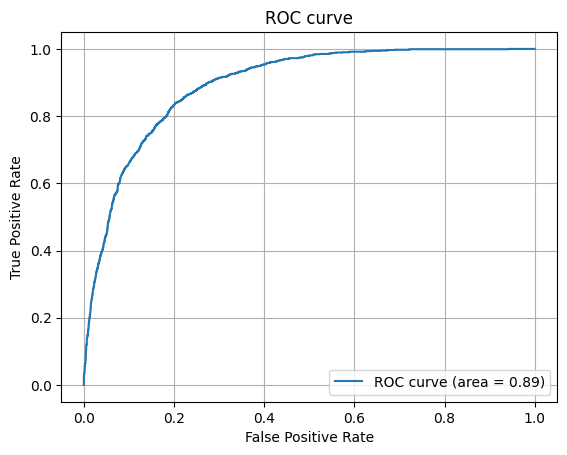

accuracy 0.8554616277142384
precision 0.6861642294713161


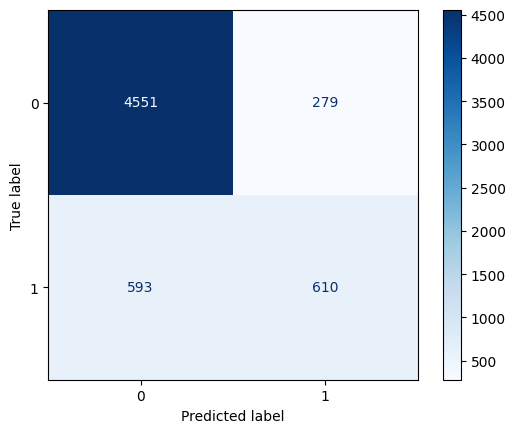

In [26]:
# AUCを計算
fpr, tpr, thresholds = roc_curve(np.asarray(y_test), y_pred)
print("AUC", auc(fpr, tpr))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc(fpr, tpr))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# accuracy, precisionを計算
acc = accuracy_score(np.asarray(y_test), np.round(y_pred))
precision = precision_score(np.asarray(y_test), np.round(y_pred))
print("accuracy", acc)
print("precision", precision)

# 混同行列をプロット
y_pred = np.round(y_pred)
cm = confusion_matrix(np.asarray(y_test), np.where(y_pred < 0.5, 0, 1))
cmp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmp.plot(cmap=plt.cm.Blues)
plt.show()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

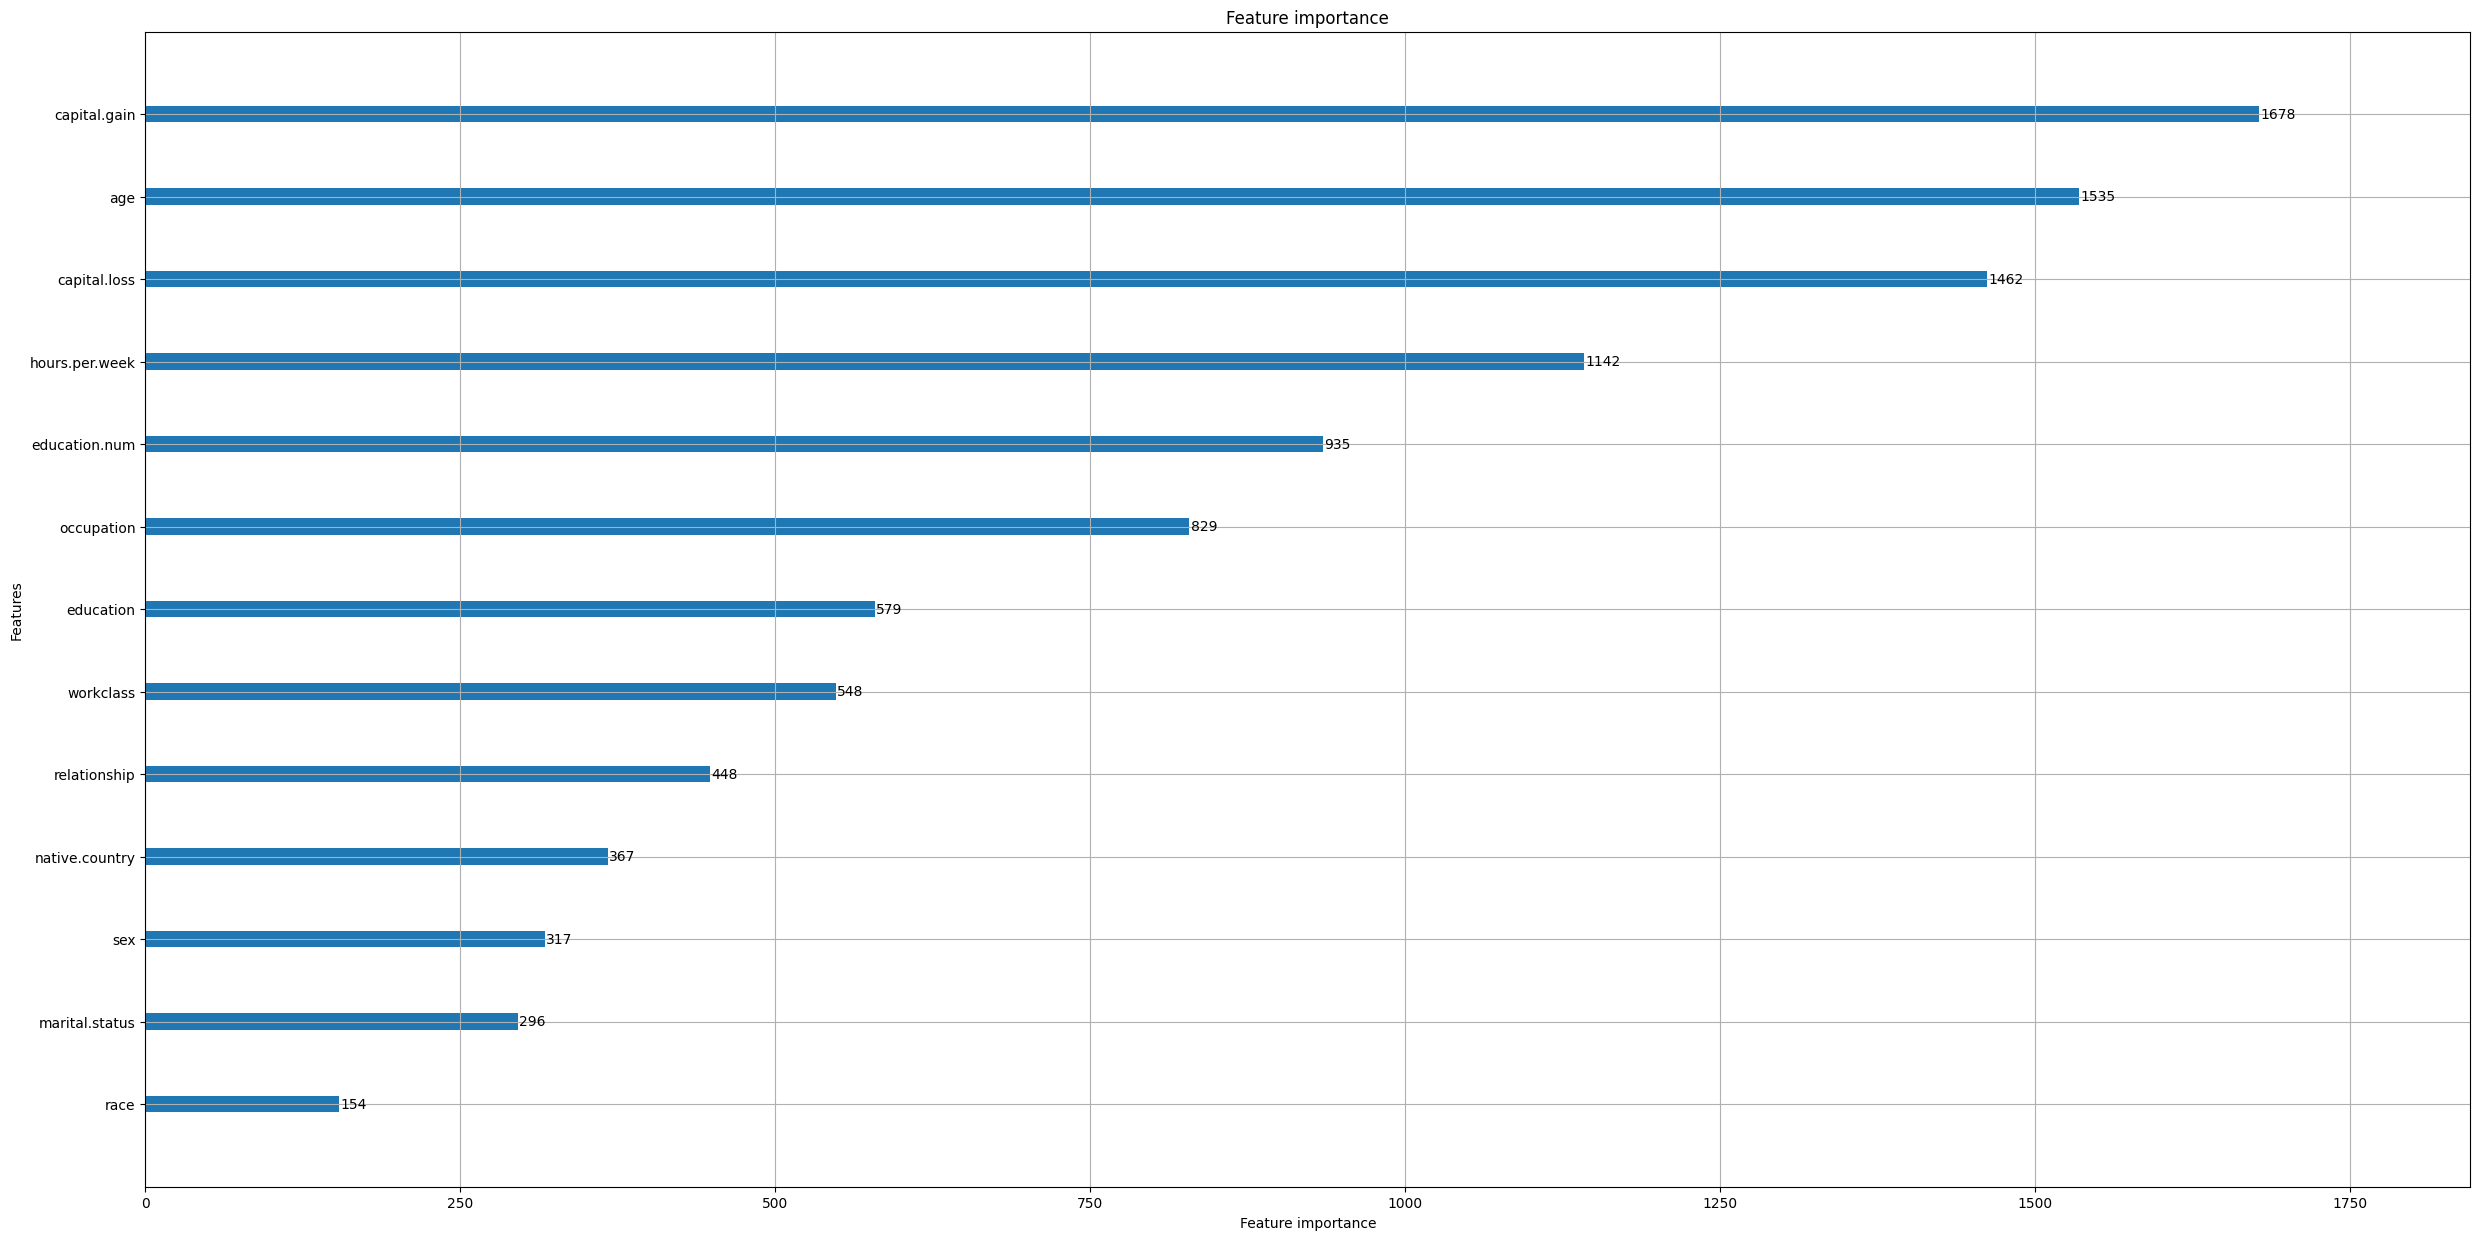

In [27]:
# 重要度としては「特徴量が分岐（ノード）の条件式で使用された回数」（＝デフォルト）
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='split')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

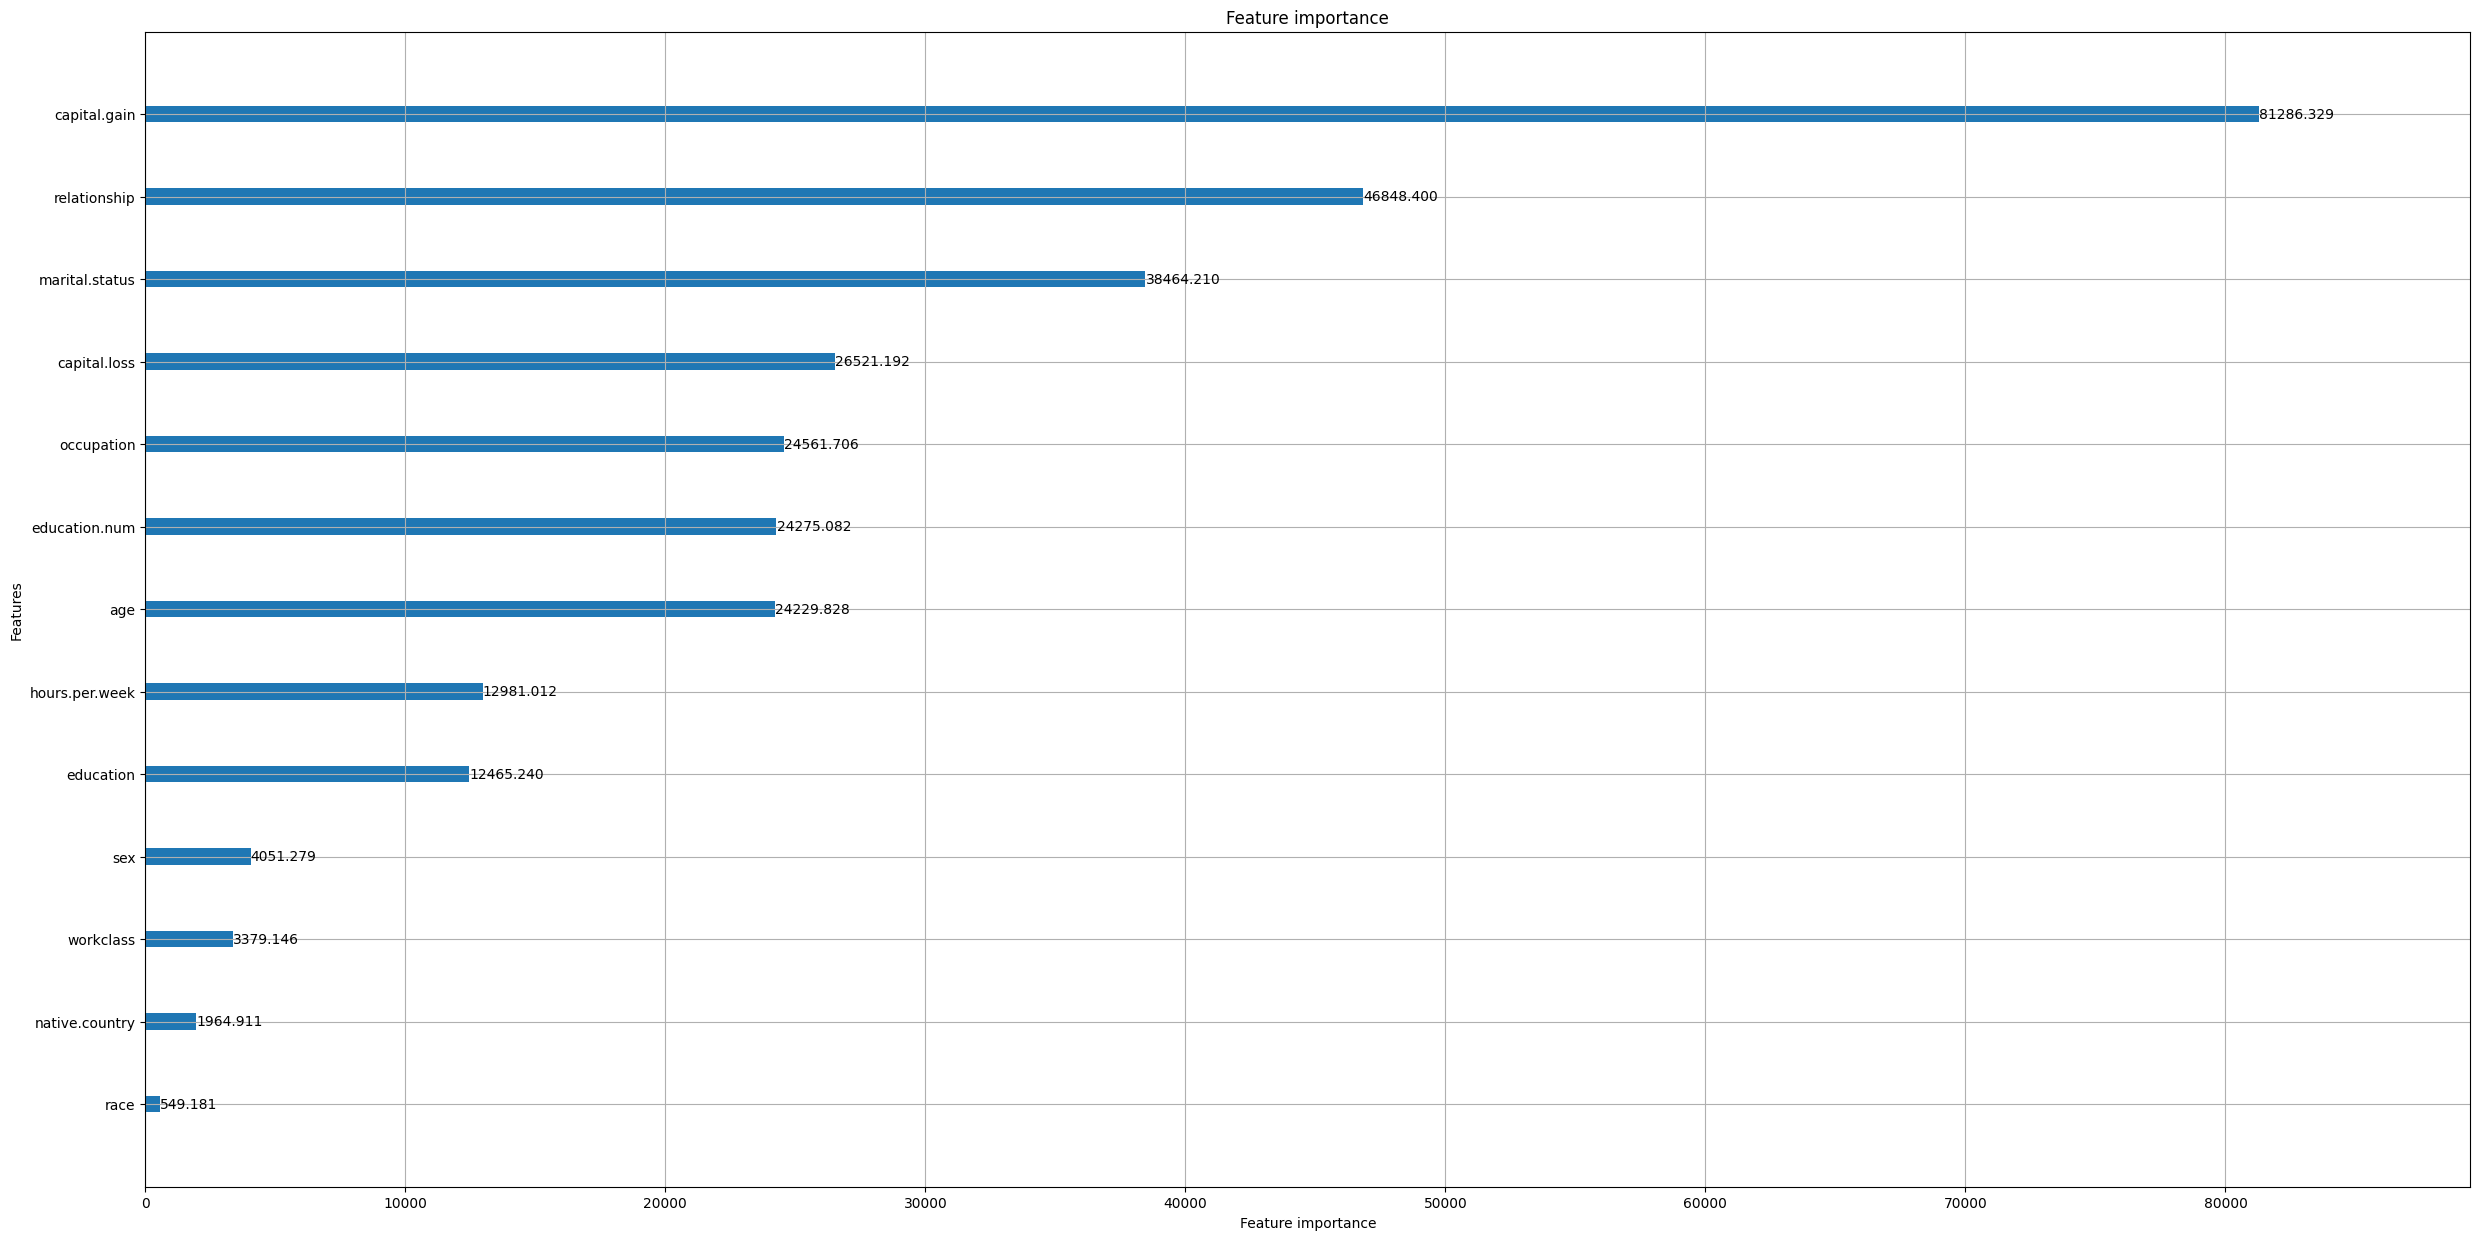

In [28]:
# 重要度としては「特徴量がある分岐（ノード）において目的関数の改善に寄与した度合い」
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='gain')

In [29]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [30]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(df.drop('income',axis=1).columns) # 特徴量名のリスト(目的変数target以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート

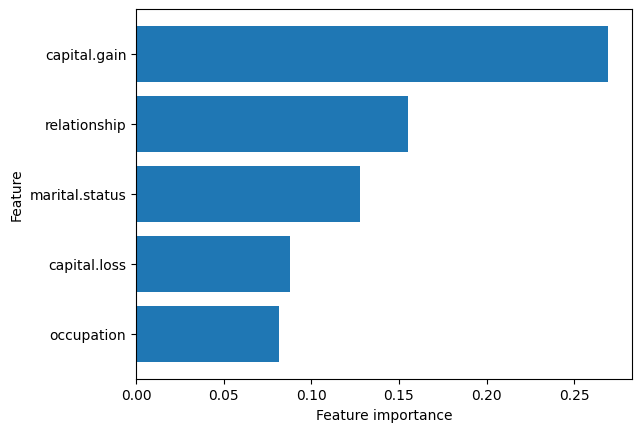

In [31]:
# 特徴量重要度の可視化
n_display = 5 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])